## Sirius/LNLS - Scientific Computing Group
## Ptychography

This notebook contains an example on how to call Ptychography using sscCdi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

import sscCdi

### Load example data

In [ ]:
data = np.load('../data/ptycho/data.npy')
positions = np.load('../data/ptycho/positions.npy')

### Define initial object and initial probe, if wanted

In [3]:
initial_obj = None
initial_probe = None

### Ptychography. The following algorithms are available:

    - RAAR_python: Relaxed Averaged Alternating Reflections. Single GPU, Python implementation using CuPy
    - ePIE_python: Extended Ptychographic Iterative Engine. Single GPU, Python implementation using CuPy
    - RAAR_cuda:   Relaxed Averaged Alternating Reflections. Multi GPU, CUDA implementation
    - AP_cuda:     Alternate Projections. Multi GPU, CUDA implementation
    - AP_PC_cuda:  Alternate Projections with Position Correction via Annealing method. Multi GPU, CUDA implementation
    - ePIE_cuda:   Extended Ptychographic Iterative Engine. Single GPU, CUDA implementation

### Inputs:
    - DPs (ndarray): diffraction data with shape (N,Y,X). N is the number of diffraction patterns.
    - positions (array): positions array with shape (N,2) with (x,y) position pairs in each line.
    - initial_obj (ndarray, optional): Initial guess for object. Shape to be determined from DPs and positions. If None, will use the input in "input_dict" to determine the initial object. Defaults to None.
    - initial_probe (ndarray, optional): Initial guess for probe of shape (M,Y,X), where M is the number of probe modes. If None, will use the input in "input_dict" to determine the initial probe. Defaults to None.
    - input_dict (dict): dictionary of input required for Ptychography. See dicitonary of inputs in the next cell for details.


### Returns:
    - obj: object matrix 
    - probe: probe matrix
    - error: error metric along iterations
    - positions: final positions of the scan (which may be corrected if AP_PC_CUDA is used)


In [5]:
input_dict = {

    "hdf5_output": './output.h5', # path to hdf5 file to contain all outputs
    
    'CPUs': 32,  # number of cpus to use in parallel execution    
    'GPUs': [0], # list of numbers (e.g. [0,1,2]) containg the number of the GPUs

    "fresnel_regime": False,
    
    'energy': 6, # energy in keV
    
    'detector_distance': 13, # meters
    
    'distance_sample_focus': 0, # float. Distance in meters between sample and focus or pinhole. This distance is used to propagated the probe prior to application of the probe support. 
    
    'detector_pixel_size': 55e-6, # meters
    
    'binning': 1, # how many times to bin data. Must be even number. if 1, no binning occurs.
    
    'position_rotation': 0, # angle in radians. Rotation applied to the positions for correcting angle between detector and probe transverse coordinates

    'object_padding': 50, # pixels. Number of pixels to add around the object matrix

    'incoherent_modes': 1, # int. Number of incoherent modes to use

    'probe_support': {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} , # support to be applied to the probe matrix after probe update. Options are:
                                                                                           # - {"type": "circular",  "radius": 300,  "center_y": 0, "center_x": 0} (0,0) is the center of the image
                                                                                           # - {"type": "cross",  "center_width": 300,  "cross_width": 0, "border_padding": 0} 
                                                                                           # - {"type": "array",  "data": myArray}

    "initial_obj": {"obj": 'random'},     # 2d array. Initial guess for the object. Options are:
                                          # - {"obj": my2darray}, numpy array 
                                          # - {"obj": 'path/to/numpyFile.npy'}, path to .npy, 
                                          # - {"obj": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                          # - {"obj": 'random'}, random matrix with values between 0 and 1
                                          # - {"obj": 'constant'}, constant matrix of 1s

    "initial_probe": { "probe": 'inverse'},   # 2d array. Initial guess for the probe. Options are:
                                          # - {"probe": my2darray}, numpy array 
                                          # - {"probe": 'path/to/numpyFile.npy'}, path to .npy, 
                                          # - {"probe": 'path/to/hdf5File.h5'}, path to .hdf5 of previous recon containing the reconstructed object in 'recon/object'
                                          # - {"probe": 'random'}, random matrix with values between 0 and 1
                                          # - {"probe": 'constant'}, constant matrix of 1s
                                          # - {"probe": 'inverse'}, matrix of the Inverse Fourier Transform of the mean of DPs.
                                          # - {"probe": 'circular', "radius": 100, "distance":0},  circular mask with a pixel of "radius". If a distance (in meters) is given, it propagated the round probe using the ASM method.

  
'Algorithm1': {'Batch': 64,
                'Beta': 0.995,
                'Epsilon': 0.01,
                'Iterations': 10,
                'Name': 'RAAR',
                'ProbeCycles': 4,
                'TV': 0},


# 'algorithms': {
    
    
# '1': {'name': 'RAAR_python',
#         'iterations': 30,
#         'regularization_object': 0.25,
#         'regularization_probe': 0.5,
#         'step_object': 0.9,
#         'step_probe': 0.9,
#         },
    
# '2': {'name': 'ePIE_python',
#         'iterations': 10,
#         'regularization_object': 0.25,
#         'regularization_probe': 0.5,
#         'step_object': 0.5,
#         'step_probe': 1,
#         'use_mPIE': False,
#         'mPIE_friction_obj': 0.9,
#         'mPIE_friction_probe': 0.99,
#         'mPIE_momentum_counter': 10,
#         },    

    
# '1': {'name': 'ePIE_python',
#         'iterations': 100,
#         'regularization_object': 0.25,
#         'regularization_probe': 0.5,
#         'step_object': 0.5,
#         'step_probe': 1,
#         'mPIE_friction_obj': 0.9,
#         'mPIE_friction_probe': 0.99,
#         'mPIE_momentum_counter': 10,
#         },
    
# '2':  {'name': 'RAAR_python',
#         'iterations': 30,
#         'regularization_object': 0.25,
#         'regularization_probe': 0.5,
#         'step_object': 0.9,
#         'step_probe': 0.9,
#         },
    
# '3': {'name':'RAAR_cuda',
#      'iterations': 100, 
#      'step_size': 0.9,
#      'epsilon': 0,
#      'total_variation': 0,
#      'batch': 64,
#      },
    
# '4': {'name':'AP_PC_cuda',
#      'iterations': 100, 
#      'step_object': 0.9,
#      'step_probe': 0.9,      
#      'epsilon': 0,
#      'probe_cycles': 4,
#      'total_variation': 0,
#      'batch': 64,
#      },
    
# '5': {'name':'AP_cuda',
#      'iterations': 100, 
#      'step_object': 0.9,
#      'step_probe': 0.9,      
#      'epsilon': 0,
#      'probe_cycles': 4,
#      'total_variation': 0,
#      'batch': 64,
#      },    
    

}



In [6]:
positions = np.roll(positions,axis=1,shift=1)
positions.shape

(81, 2)

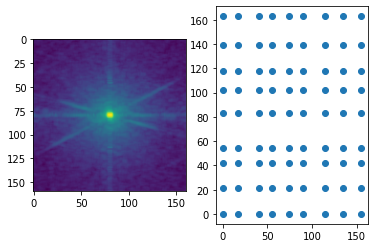

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(data.mean(0),norm=LogNorm())
ax[1].plot(positions[:,0],positions[:,1],'o')

In [7]:
recon_obj, recon_probe, recon_error, recon_positions = sscCdi.call_ptychography(input_dict,data, positions, initial_obj=initial_obj, initial_probe=initial_probe)

Pixel size = 55.00 um
Energy = 6 keV
Wavelength = 0.207 nm
Object pixel = 305.26 nm
Object shape: (365, 373)
Creating initial probe...
Probe shape (160,160) with 1 incoherent mode(s)
Creating initial object...
Setting probe support...
Calling 30 iterations of RAAR algorithm...
	Iteration 30/30 	Error: 4.22e-01Calling 10 iterations of ePIE algorithm...


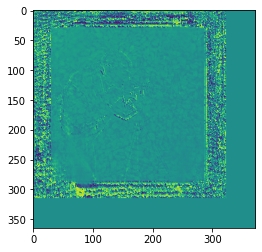

In [8]:
plt.figure()
plt.imshow(np.angle(recon_obj[0]))